# Model visualization

## Cubes

## Posterior slices

In [ ]:
from numpyro.infer.util import log_density

log_density_fn = lambda xx_ij, yy_ij, to_marg: log_density(
                            model=forward_model, 
                            model_args=(), 
                            model_kwargs=model_kwargs, 
                            params={'Omega_c_base':xx_ij, 
                                    'sigma8_base':yy_ij, 
                                    'init_mesh_base':to_marg,
                                    'obs_mesh':obs_values['obs_mesh'],},)[0]
log_density_jit = jit(vmap(vmap(vmap(log_density_fn, in_axes=(0,0,None)), in_axes=(0,0,None)), in_axes=(None, None, 0)))
# zz = jnp.array([[log_density(forward_model, (), model_kwargs,
#                               {'Omega_c_base':xx_ij, 'sigma8_base':yy_ij, 'init_mesh_base':init_values['init_mesh_base'],'obs_mesh':obs_values['obs_mesh'],})[0] 
#                               for xx_ij, yy_ij in zip(xx_i, yy_i)] for xx_i, yy_i in zip(xx, yy)]) # unefficient implementation

box_corner = 1
n_discr = 40
box = np.array([[-1, box_corner], [-2, box_corner]])
xx, yy = np.mgrid[[slice(box_ax[0],box_ax[1],n_discr*1j) 
                       for box_ax in box]] # to get distances
print(f"shape={log_density_jit(xx, yy, jnp.expand_dims(init_values['init_mesh_base'], 0)).shape}")

shape=(1, 40, 40)


In [ ]:
n_fields = 12
logp_meshes = np.empty((n_fields, n_discr, n_discr))
sample_shape = (n_fields-1, *model_kwargs['mesh_size'])
fields = dist.Normal(jnp.zeros(sample_shape), jnp.ones(sample_shape)/2).sample(random.PRNGKey(0))
field_norms = jnp.sum(fields**2, axis=(1,2,3))
arg_field_norms = jnp.argsort(field_norms)
fields = fields[arg_field_norms]
fields = fields + init_values['init_mesh_base']
fields = jnp.concatenate((jnp.expand_dims(init_values['init_mesh_base'], 0), fields))
n_per_loop = 1
for i in range(n_fields//n_per_loop):
    logp_meshes[n_per_loop*i:n_per_loop*(i+1)] = log_density_jit(xx, yy, fields[n_per_loop*i:n_per_loop*(i+1)])
np.save(save_path+"_logp", logp_meshes)
print(f"logp_meshes shape={logp_meshes.shape} so number of logp eval={np.prod(logp_meshes.shape)}")

logp_meshes shape=(12, 40, 40) so number of logp eval=19200


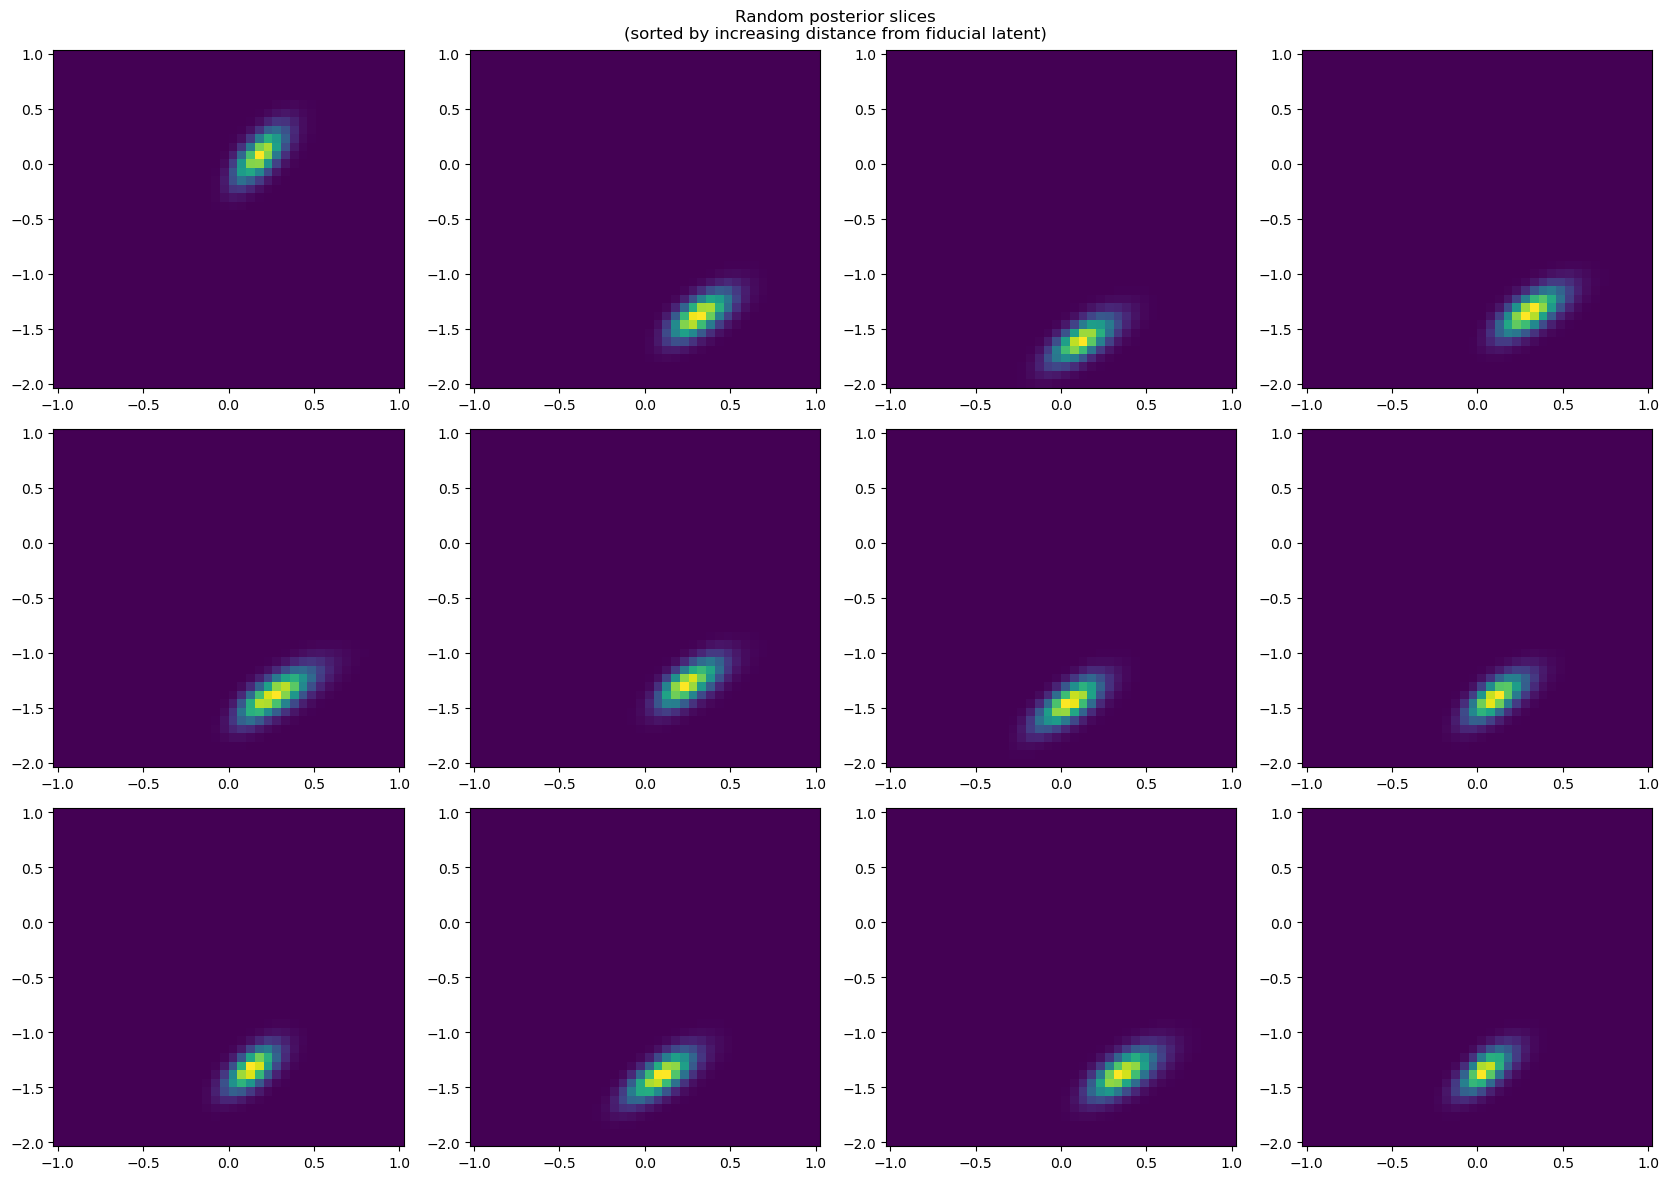

In [ ]:
n_subplots = len(logp_meshes)
n_rows = 3
n_cols = int(np.ceil(n_subplots/n_rows))
plt.figure(figsize=(n_cols*4.2, n_rows*4))
for i_subplot in range(n_subplots):
    ax3D = plt.subplot(n_rows, int(np.ceil(n_subplots/n_rows)), i_subplot+1)
    # p3d = ax3D.pcolormesh(xx, yy, zz, cmap='viridis')
    p_mesh = jnp.exp(logp_meshes[i_subplot] - jnp.max(logp_meshes[i_subplot]))
    plt.pcolormesh(xx, yy, p_mesh, cmap='viridis')
    # plt.pcolormesh(xx, yy, logp_meshes[i_subplot], cmap='viridis')
    # p3d = ax3D.pcolormesh(xx, yy, p_mesh, cmap='viridis')
    # ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)")
    # plt.colorbar()
plt.suptitle("Random posterior slices\n(sorted by increasing distance from fiducial latent)")
plt.savefig(save_path+"_postslice")
plt.tight_layout(), plt.show();

## Posterior dimensionality reduction